In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()
chat_model=ChatGroq(model="llama3-8b-8192")

In [2]:
import operator
from typing import TypedDict, Literal, Dict
from typing_extensions import Annotated

class BlogState(TypedDict, total=False):
    # User input
    input: dict
    inputCategory: Literal["link", "topic"]

    # YouTube details
    youtubeVideoId: str
    topic: str
    youtubeSubtitles: str

    # Generated content
    title: str
    content: str
    blog: Dict

    # Human-in-the-loop approval
    approved: bool
    feedback: str
    feedback_history: Annotated[list[str], operator.add]

    # Posting destination
    postMedia: Literal["fb", "instagram"]

    # Instagram-only
    image_url: str  

    # Final post structure
    finalpost: Dict


In [3]:
import re
from typing import Dict

YOUTUBE_REGEX = r"(?:youtu\.be/|youtube\.com/(?:watch\?v=|embed/|v/))([a-zA-Z0-9_-]{11})"

def determine_input(state: BlogState) -> Dict:
    """
    Determine whether the input is a YouTube link or a custom topic.
    Also loads image_url if provided in the input dict.
    
    Expected state["input"] format:
    {
        "text": "<youtube link OR topic>",
        "image_url": "<optional image URL>"
    }
    
    Updates state with:
      - inputCategory ("link" or "topic")
      - youtubeVideoId (if link)
      - topic (if topic)
      - image_url (if provided)
    """
    input_data = state.get("input", {})
    if not isinstance(input_data, dict):
        raise ValueError("State 'input' must be a dict with keys 'text' and optional 'image_url'")

    input_text = input_data.get("text", "").strip()
    image_url = input_data.get("image_url", "").strip()

    # Try matching YouTube video ID from input_text
    match = re.search(YOUTUBE_REGEX, input_text)
    if match:
        youtube_id = match.group(1)
        return {
            "inputCategory": "link",
            "youtubeVideoId": youtube_id,
            "image_url": image_url
        }
    else:
        # Treat as a topic
        return {
            "inputCategory": "topic",
            "topic": input_text,
            "image_url": image_url
        }


In [4]:
from youtube_transcript_api import YouTubeTranscriptApi
from typing import Dict

def fetch_youtube_subtitles(state: BlogState) -> Dict:
    """
    Node to fetch subtitles of a YouTube video.
    Updates state with 'youtubeSubtitles'.
    """
    video_id = state.get("youtubeVideoId")
    if not video_id:
        raise ValueError("youtubeVideoId not found in state")

    try:
        ytt_api = YouTubeTranscriptApi()
        fetched_transcript = ytt_api.fetch(video_id)
        combined_text = " ".join(snippet.text for snippet in fetched_transcript)
        return {
            "youtubeSubtitles": combined_text
        }
    except Exception as e:
        raise RuntimeError(f"Failed to fetch subtitles for video {video_id}: {str(e)}")


In [5]:
def parallel_title_content_start(state:BlogState):
    print(state.get("title"),"  ",state.get("content"))

In [6]:
def generate_blog_title(state: BlogState) -> Dict:
    transcript = state.get("youtubeSubtitles")
    feedback = state.get("feedback", "")
    feedback_history = state.get("feedback_history", [])

    if not transcript:
        raise ValueError("Transcript not found in state")

    prompt = f"""Generate an engaging, SEO-friendly blog title 
based on this transcript. Improve clarity and clickability.

Transcript:
{transcript}

Latest Human Feedback (if any):
{feedback}

Previous Feedback History:
{feedback_history}
"""
    response = chat_model.invoke(prompt)
    title = getattr(response, "content", str(response))
    return {"title": title.strip()}


In [7]:
def generate_blog_content(state: BlogState) -> Dict:
    transcript = state.get("youtubeSubtitles")
    feedback = state.get("feedback", "")
    feedback_history = state.get("feedback_history", [])

    if not transcript:
        raise ValueError("Transcript not found in state")

    prompt = f"""Expand this transcript into a well-structured, reader-friendly blog article. 
Make sure to include:
- An engaging introduction
- A clear body with well-separated sections
- A concise conclusion

Transcript:
{transcript}

Latest Human Feedback (if any):
{feedback}

Previous Feedback History:
{feedback_history}
"""
    response = chat_model.invoke(prompt)
    content = getattr(response, "content", str(response))
    return {"content": content.strip()}


In [8]:
def compose_final_blog(state: BlogState) -> Dict:
    title = state.get("title")
    content = state.get("content")
    feedback = state.get("feedback", "")
    feedback_history = state.get("feedback_history", [])

    if not title or not content:
        raise ValueError("Both title and content must be present in state")

    prompt = f"""You are a professional blog writer. 
Take the following draft title and content, and refine them into a polished, 
engaging blog post suitable for publishing. 
Keep the original meaning but improve flow, readability, and SEO.

Draft Title:
{title}

Draft Content:
{content}

Latest Human Feedback (if any):
{feedback}

Previous Feedback History:
{feedback_history}
"""
    response = chat_model.invoke(prompt)
    final_blog = getattr(response, "content", str(response))

    return {
        "blog": {
            "title": title.strip(),
            "content": final_blog.strip()
        }
    }


In [9]:
def human_approval_node(state: BlogState) -> Dict:
    """
    Node that pauses workflow for human approval.
    Updates state with approval status, latest feedback, and appends to feedback_history.
    """
    blog = state.get("blog", {})
    if not blog:
        raise ValueError("No blog found in state to review")

    print("\n--- Blog Preview ---")
    print("Title:", blog.get("title", ""))
    print("Content:\n", blog.get("content", ""))
    print("-------------------\n")

    decision = input("Approve blog? (yes/no): ").strip().lower()

    if decision in ["yes", "y"]:
        return {"approved": True}
    else:
        feedback = input("Enter feedback for regeneration: ").strip()
        return {
            "approved": False,
            "feedback": feedback,
            "feedback_history": [feedback]  # reducer appends it
        }


In [10]:
from typing import Dict

def choose_post_media_node(state: BlogState) -> Dict:
    """
    HITL node that asks human where to post the final blog.
    Updates state with 'postMedia' = 'fb' or 'instagram'.
    """
    blog = state.get("blog", {})
    if not blog:
        raise ValueError("No blog found in state to decide posting")

    print("\n--- Blog Ready for Posting ---")
    print("Title:", blog.get("title", ""))
    print("------------------------------\n")

    choice = None
    while choice not in ["fb", "instagram"]:
        choice = input("Where do you want to post? (fb/instagram): ").strip().lower()

    return {"postMedia": choice}


In [11]:
import os
import requests

def publish_blog_to_facebook(final_blog: dict) -> dict:
    """
    Publishes a blog post to a Facebook Page feed, then retrieves its id, message, and created_time.
    
    Environment Variables:
        FACEBOOK_PAGE_ID            – the target Page ID
        FACEBOOK_PAGE_TOKEN         – a valid Page access token
        FACEBOOK_GRAPH_API_VERSION  – Graph API version (default: v16.0)
    
    Args:
        final_blog: A dict with keys "title" and "content".
    
    Returns:
        A dict containing the published post's id, message, and created_time.
    
    Raises:
        RuntimeError: If either the POST or GET request fails.
    """
    page_id            = os.getenv("FACEBOOK_PAGE_ID")
    page_access_token  = os.getenv("FACEBOOK_PAGE_TOKEN")
    graph_api_version  = os.getenv("FACEBOOK_GRAPH_API_VERSION", "v16.0")

    if not page_id or not page_access_token:
        raise RuntimeError("Missing FACEBOOK_PAGE_ID or FACEBOOK_PAGE_TOKEN environment variable")

    message_text = f"{final_blog.get('title', '')}\n\n{final_blog.get('content', '')}"

    post_url = f"https://graph.facebook.com/{graph_api_version}/{page_id}/feed"
    post_params = {
        "message": message_text,
        "access_token": page_access_token
    }
    post_resp = requests.post(post_url, data=post_params)
    if not post_resp.ok:
        raise RuntimeError(f"Failed to publish post: {post_resp.text}")
    post_id = post_resp.json().get("id")
    if not post_id:
        raise RuntimeError(f"No post ID returned: {post_resp.text}")

    # 2) GET /{post_id}?fields=id,message,created_time
    get_url = f"https://graph.facebook.com/{graph_api_version}/{post_id}"
    get_params = {
        "fields": "id,message,created_time",
        "access_token": page_access_token
    }
    get_resp = requests.get(get_url, params=get_params)
    if not get_resp.ok:
        raise RuntimeError(f"Failed to retrieve post data: {get_resp.text}")

    return get_resp.json()


In [12]:
from typing import Dict

def publish_to_facebook_node(state: BlogState) -> Dict:
    """
    LangGraph node wrapper for publishing a blog post to Facebook.
    Uses the `publish_blog_to_facebook` function.
    Updates state with 'finalpost'.
    """
    blog = state.get("blog", {})
    if not blog:
        raise ValueError("No blog found in state to publish")

    try:
        result = publish_blog_to_facebook(blog)
        return {"finalpost": result}
    except Exception as e:
        raise RuntimeError(f"Facebook publishing failed: {str(e)}")


In [13]:
import os
import requests
from typing import Dict

def publish_blog_to_instagram(state: Dict) -> Dict:
    """
    Publishes a blog post to Instagram by creating a media object and publishing it.
    Reads 'blog' and 'image_url' from state, then updates 'finalpost'.
    
    Environment Variables:
        INSTAGRAM_PAGE_ID           – the Instagram Business Account ID (not user ID!)
        FACEBOOK_PAGE_TOKEN         – a valid Page access token (with instagram_basic, pages_show_list, instagram_content_publish)
        FACEBOOK_GRAPH_API_VERSION  – Graph API version (default: v16.0)
    """
    ig_account_id     = os.getenv("INSTAGRAM_PAGE_ID")
    access_token      = os.getenv("FACEBOOK_PAGE_TOKEN")
    graph_api_version = os.getenv("FACEBOOK_GRAPH_API_VERSION", "v16.0")

    if not ig_account_id or not access_token:
        raise RuntimeError("Missing INSTAGRAM_PAGE_ID or FACEBOOK_PAGE_TOKEN environment variables")

    blog = state.get("blog", {})
    image_url = state.get("image_url", "")

    if not blog:
        raise ValueError("No blog found in state to publish")
    if not image_url:
        raise ValueError("No image_url found in state for Instagram post")

    caption_text = f"{blog.get('title', '')}\n\n{blog.get('content', '')}"

    # Step 1: Create media object
    media_url = f"https://graph.facebook.com/{graph_api_version}/{ig_account_id}/media"
    media_params = {
        "image_url": image_url,
        "caption": caption_text,
        "access_token": access_token
    }
    media_resp = requests.post(media_url, data=media_params)
    if not media_resp.ok:
        raise RuntimeError(f"Failed to create Instagram media: {media_resp.text}")
    media_id = media_resp.json().get("id")
    if not media_id:
        raise RuntimeError(f"No media ID returned: {media_resp.text}")

    # Step 2: Publish the media object
    publish_url = f"https://graph.facebook.com/{graph_api_version}/{ig_account_id}/media_publish"
    publish_params = {
        "creation_id": media_id,
        "access_token": access_token
    }
    publish_resp = requests.post(publish_url, data=publish_params)
    if not publish_resp.ok:
        raise RuntimeError(f"Failed to publish Instagram post: {publish_resp.text}")

    # Return updated state with finalpost
    return {
        "finalpost": publish_resp.json()
    }


In [14]:
from typing import Dict

def publish_to_instagram_node(state: BlogState) -> Dict:
    """
    LangGraph node wrapper for Instagram publishing.
    Uses state's image_url.
    Updates state with 'finalpost'.
    """
    blog = state.get("blog", {})
    image_url = state.get("image_url")

    if not blog:
        raise ValueError("No blog found in state to publish")
    if not image_url:
        raise ValueError("No image_url found in state for Instagram post")

    try:
        result = publish_blog_to_instagram(blog, image_url)
        return {"finalpost": result}
    except Exception as e:
        raise RuntimeError(f"Instagram publishing failed: {str(e)}")


In [15]:
def publish_router_node(state: BlogState) -> Dict:
    """
    Routes workflow based on state['postMedia'].
    Returns empty dict — edges will connect to FB or IG node.
    """
    choice = state.get("postMedia")
    if choice == "fb":
        return {"route": "facebook"}
    elif choice == "instagram":
        return {"route": "instagram"}
    else:
        raise ValueError("Invalid postMedia: must be 'fb' or 'instagram'")

In [16]:
from langgraph.graph import StateGraph
from typing import Dict


graph = StateGraph(BlogState)

# Register nodes
graph.add_node("determine_input", determine_input)
graph.add_node("fetch_youtube_transcript", fetch_youtube_subtitles)
graph.add_node("preprocessor",parallel_title_content_start)
graph.add_node("generate_title", generate_blog_title)
graph.add_node("generate_content", generate_blog_content)
graph.add_node("compose_blog", compose_final_blog)
graph.add_node("human_approval", human_approval_node)
graph.add_node("choose_post_media", choose_post_media_node)
graph.add_node("publish_router", publish_router_node)
graph.add_node("publish_facebook", publish_to_facebook_node)
graph.add_node("publish_instagram", publish_to_instagram_node)



In [17]:
# Entry point
graph.set_entry_point("determine_input")

# 1) determine_input → conditional: YouTube link vs topic
def route_input(state: Dict) -> str:
    if state.get("inputCategory") == "link":
        return "fetch_youtube_transcript"
    elif state.get("inputCategory") == "topic":
        return "preprocessor"
    else:
        raise ValueError("Unknown inputCategory")

graph.add_conditional_edges(
    "determine_input",
    route_input,
    {
        "fetch_youtube_transcript": "fetch_youtube_transcript",
        "preprocessor": "preprocessor"
    },
)

# 2) fetch_youtube_transcript → preprocessor
graph.add_edge("fetch_youtube_transcript", "preprocessor")

# 3) preprocessor → generate_title + generate_content (parallel)
graph.add_edge("preprocessor", "generate_title")
graph.add_edge("preprocessor", "generate_content")

# 4) title & content → compose_blog (after both done)
graph.add_edge("generate_title", "compose_blog")
graph.add_edge("generate_content", "compose_blog")

# 5) compose_blog → human_approval
graph.add_edge("compose_blog", "human_approval")

# 6) human_approval → conditional: approved vs rejected
def approval_router(state: Dict) -> str:
    if state.get("approved") is True:
        return "choose_post_media"
    else:
        return "preprocessor"  # regenerate

graph.add_conditional_edges(
    "human_approval",
    approval_router,
    {
        "choose_post_media": "choose_post_media",
        "preprocessor": "preprocessor"
    },
)

# 7) choose_post_media → publish_router
graph.add_edge("choose_post_media", "publish_router")

# 8) publish_router → conditional fb vs instagram
def post_router(state: Dict) -> str:
    if state.get("postMedia") == "fb":
        return "publish_facebook"
    elif state.get("postMedia") == "instagram":
        return "publish_instagram"
    else:
        raise ValueError("Invalid postMedia value")

graph.add_conditional_edges(
    "publish_router",
    post_router,
    {
        "publish_facebook": "publish_facebook",
        "publish_instagram": "publish_instagram"
    },
)

# 9) End nodes
graph.add_edge("publish_facebook", "__end__")
graph.add_edge("publish_instagram", "__end__")


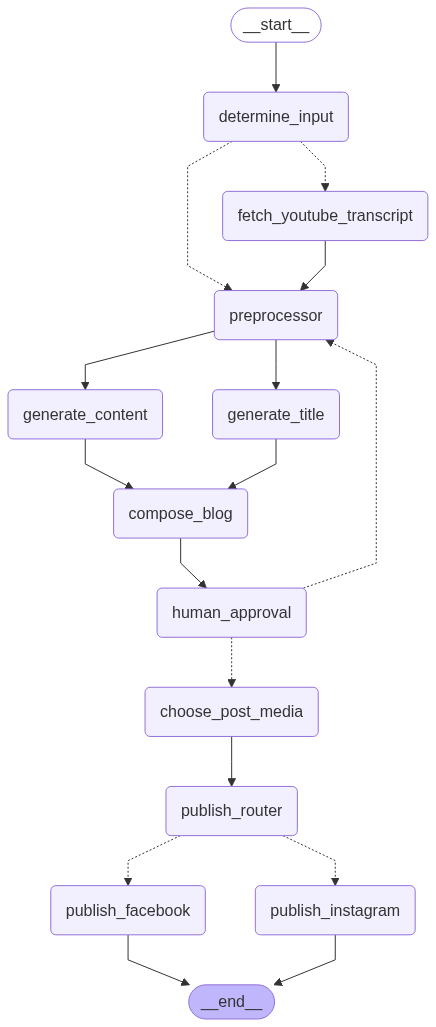

In [18]:
app = graph.compile()
app

In [19]:
from typing import Dict

# -----------------------------
# 1) Define initial state
# -----------------------------
initial_state: BlogState = {
    "input": {
        # Either a YouTube link or a topic
        "text":"https://www.youtube.com/watch?v=PfxabSYFs88&ab_channel=ThingsICantFindOtherwise"
    },
    # Defaults / empty
    "inputCategory": "",
    "youtubeVideoId": "",
    "topic": "",
    "youtubeSubtitles": "",
    "title": "",
    "content": "",
    "blog": {},
    "approved": False,
    "feedback": "",
    "feedback_history": [],
    "postMedia": "",       # will be chosen in HITL node
    "image_url": "",       # will be set from input
    "finalpost": {}
} # type: ignore


In [20]:

# -----------------------------
# 2) Invoke workflow
# -----------------------------
try:
    # `run` executes the graph starting from the entry point
    final_state: Dict = app.invoke(initial_state)

    print("Workflow completed successfully!")
    print("Final State:")
    print(final_state)

except Exception as e:
    print("Workflow failed with error:", str(e))


    

--- Blog Preview ---
Title: Here are a few options for an engaging, SEO-friendly blog title based on the transcript:

1. **"The Mad Magazine Memory that Led to a POW's Punishing Punishment"** (Keyword: "Mad Magazine")
2. **"A Slogan, a Stew, and a Lifetime of Regret: The Unforgettable Consequences of a T-Shirt"** (Keyword: "Consequences")
3. **"When a Mad Magazine Tee Led to a POW's Three-Year Nightmare"** (Keyword: "POW")
4. **"The Unlikely Source of a POW's Punishment: A Mad Magazine Slogan and a Moment of Mischief"** (Keyword: "Mischief")
5. **"From Iron-On to Isolation: The Bizarre Story Behind a POW's Punishment"** (Keyword: "POW")

To improve clarity and clickability, I've aimed to:

* Use attention-grabbing language to entice readers
* Highlight the unexpected twist of a Mad Magazine slogan leading to a POW's punishment
* Include relevant keywords to improve SEO
* Keep the title concise and easy to read
* Use a mix of action words (e.g., "led", "nightmare", "bizarre") to c